# Kepler TTV estimation

This notebook shows how to use PyTransit in the Kepler planet TTV estimation. The code uses the `TTVLPF` log posterior function class from `pytransit.lpf.ttvlpf`, which is given a set of  Kepler-observed light curves.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
import seaborn as sb
import warnings
from kplr import API
from astropy.table import Table
import astropy.io.fits as pf

from pytransit.lpf.tdvlpf import TDVLPF
from pytransit.lpf.ttvlpf import TTVLPF
from pytransit.param.parameter import LParameter, UniformPrior as UP

from pytransit.utils.keplerlc import KeplerLC

In [12]:
class KeplerTDVLPF(TTVLPF):
    def __init__(self, planet_name=None, koi=None, qrt_min=0, qrt_max=inf, nsamples=10,
                 trdur=0.125, bldur=0.3, tc_sigma=0.05):
        api = API()
        
        if planet_name:
            self.planet = planet = api.planet(planet_name)
        elif koi:
            self.planet = planet = api.koi(koi)
        else:
            raise NotImplementedError
            
        lcs = planet.get_light_curves(short_cadence=False, fetch=True)
        time, flux, quarter = [], [], []
        for lc in lcs[qrt_min:qrt_max]:
            tb = Table.read(lc.filename)
            time.append(tb['TIME'])
            flux.append(tb['PDCSAP_FLUX'])
            quarter.append(full(time[-1].size, pf.getval(lc.filename, 'quarter')))
        time, flux, quarter = map(concatenate, (time, flux, quarter))
        
        self.lc = lc = KeplerLC(time, flux, quarter, planet.koi_time0bk, planet.koi_period, trdur, bldur)
        super().__init__(planet_name, planet.koi_time0bk, planet.koi_period, tc_sigma, ['Kp'], 
             times=lc.time_per_transit, fluxes=lc.normalized_flux_per_transit,
             pbids=lc.nt*[0], nsamples=nsamples)
 

    def _init_p_noise(self):
        """Noise parameter initialisation.
        """
        pns = [LParameter('log_err', 'log_error', '', UP(-8, -0), bounds=(-8, -0))]
        self.ps.add_lightcurve_block('log_err', 1, 1, pns)
        self._sl_err = self.ps.blocks[-1].slice
        self._start_err = self.ps.blocks[-1].start

In [13]:
lpf = KeplerTDVLPF(planet_name='kepler-2b', qrt_min=1, qrt_max=2)

In [15]:
lpf.ps

[  0 |G| rho        [0.00 ..  inf],
   1 |G| b          [0.00 .. 1.00],
   2 |G| tc_5       [-inf ..  inf],
   3 |G| tc_6       [-inf ..  inf],
   4 |G| tc_7       [-inf ..  inf],
   5 |G| tc_8       [-inf ..  inf],
   6 |G| tc_9       [-inf ..  inf],
   7 |G| tc_10      [-inf ..  inf],
   8 |G| tc_11      [-inf ..  inf],
   9 |G| tc_12      [-inf ..  inf],
  10 |G| tc_13      [-inf ..  inf],
  11 |G| tc_14      [-inf ..  inf],
  12 |G| tc_16      [-inf ..  inf],
  13 |G| tc_17      [-inf ..  inf],
  14 |G| tc_18      [-inf ..  inf],
  15 |G| tc_19      [-inf ..  inf],
  16 |P| k2         [0.00 .. 0.30],
  17 |P| q1_0       [0.00 .. 1.00],
  18 |P| q2_0       [0.00 .. 1.00],
  19 |L| log_err    [-8.00 .. 0.00]]

In [7]:
lpf.optimize_global(500, npop=100)

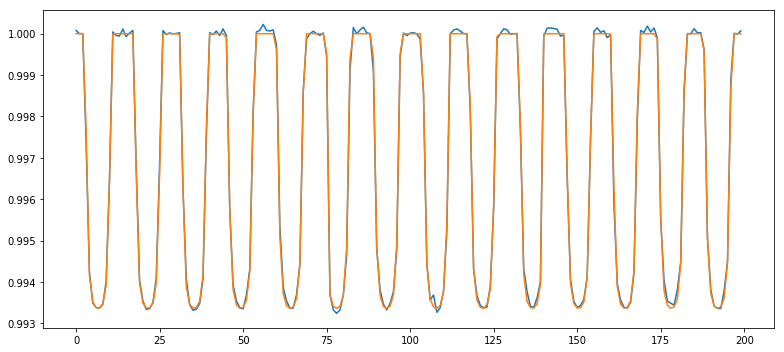

In [8]:
lpf.plot_light_curve(figsize=(11,5), time=False);

In [9]:
lpf.sample_mcmc(2000)
lpf.sample_mcmc(2000, reset=True)

In [10]:
df = lpf.posterior_samples()

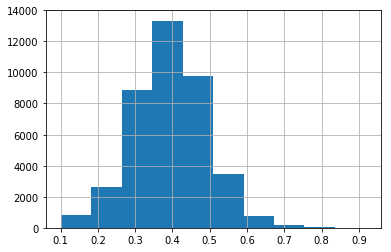

In [11]:
df.rho.hist()

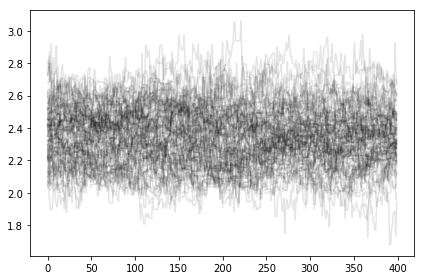

In [12]:
lpf.plot_mcmc_chains(17);

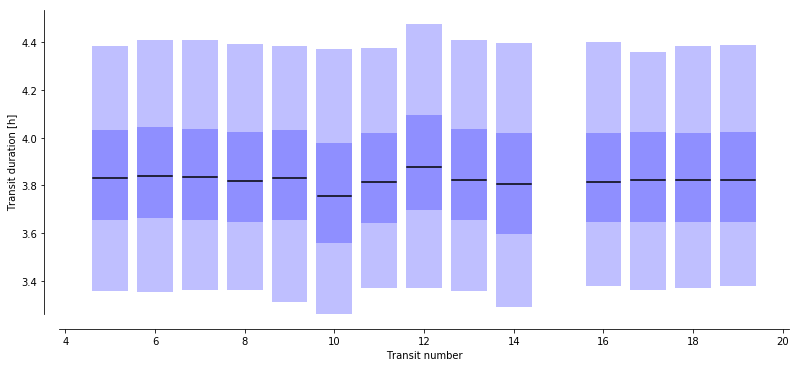

In [14]:
lpf.plot_tdvs(figsize=(11,5));

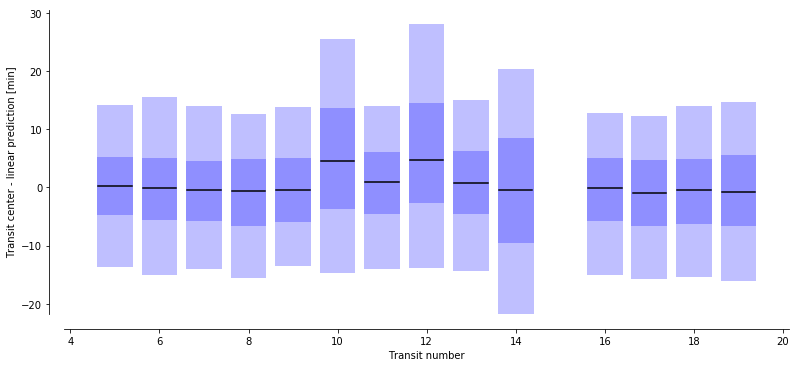

In [15]:
lpf.plot_ttvs(figsize=(11,5));

----
<center> © 2019 Hannu Parviainen </center>